![](https://www.dii.uchile.cl/wp-content/uploads/2021/06/Magi%CC%81ster-en-Ciencia-de-Datos.png)

# Proyecto: Riesgo en el Banco Giturra

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Gabriel Iturra, Ignacio Meza De La Jara
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

_Por favor, lean detalladamente las instrucciones de la tarea antes de empezar a escribir._

---

## Reglas

- Fecha de entrega: 19/12/2023
- **Grupos de 2 personas.**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Estrictamente prohibida la copia.
- Pueden usar cualquier material del curso que estimen conveniente.

---

### Integrantes:
- Nicolás Acevedo
- Fabiola Pizarro

### **Link de repositorio de GitHub:** `https://github.com/nicoacevedor/MDS7202`


# Presentación del Problema


### Introducción

Giturra busca mejorar la gestión de riesgos en su banco mediante la implementación de un modelo de riesgo crediticio que evalúe la probabilidad de incumplimiento de pago de los clientes. Además, se enfoca en la interpretabilidad del modelo para que su equipo pueda comprender y explicar las decisiones crediticias. 

Los datos **info de los datos**

Para evaluar el rendimiento de los modelos decidimos utilizar la métrica `recall` aplicada a la predicción de las personas que no pagan. Ya que los datos están desbalanceados, y el objetivo del problema es poder predecir si una persona pagará o no, creemos que esta métrica, la cual es interpretable como "de los que no pagan, cuantos fueron detectados", nos va a permitir verificar si el modelo funciona o no, y poder darle los resultados al banquero de una mejor manera.

**falta final de la intro**

### Importación de librerías a utilizar

In [35]:
from lightgbm import LGBMClassifier
import optuna
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgbm
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Configuraciones generales del proyecto

In [2]:
random_state = 42
train_size = 0.7
val_size = 0.2

### Análisis exploratiorio de los datos

In [3]:
df_raw = pd.read_parquet("dataset.pq")
print(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               12500 non-null  object 
 1   age                       12500 non-null  float64
 2   occupation                12500 non-null  object 
 3   annual_income             12500 non-null  float64
 4   monthly_inhand_salary     10584 non-null  float64
 5   num_bank_accounts         12500 non-null  int64  
 6   num_credit_card           12500 non-null  int64  
 7   interest_rate             12500 non-null  int64  
 8   num_of_loan               12500 non-null  float64
 9   delay_from_due_date       12500 non-null  int64  
 10  num_of_delayed_payment    11660 non-null  float64
 11  changed_credit_limit      12246 non-null  float64
 12  num_credit_inquiries      12243 non-null  float64
 13  outstanding_debt          12500 non-null  float64
 14  credit

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0


In [4]:
df_raw['credit_score'].value_counts(normalize=True)

credit_score
0    0.71184
1    0.28816
Name: proportion, dtype: float64

### 3. Preparación de Datos

In [5]:
# Limpieza
df = df_raw.copy()
# Edad entre 14 y 100
df = df[(df['age'] >= 14) & (df['age'] <= 100)]
# interés máximo de 100%
df = df[df['interest_rate'] <= 100]
# eliminar valores negativos
df = df[df['num_of_loan'] >= 0]
df = df[df['num_bank_accounts'] >= 0]
df = df[df['delay_from_due_date'] >= 0]
df = df[df['num_of_delayed_payment'] >= 0]
# la borré porque creo que no sirve pal proyecto
df = df.drop(columns=['customer_id'])

In [6]:
df.shape

(10528, 21)

#### 3.1 Preprocesamiento con `ColumnTransformer`

In [7]:
# Se cambian los tipos de datos
df['age'] = df['age'].astype('int64')
df['num_of_loan'] = df['num_of_loan'].astype('int64')
df['delay_from_due_date'] = df['delay_from_due_date'].astype('float64')

In [8]:
# Función para generar el scaler en todas las partes que se necesite
def generate_scaler(numeric_cols, categorical_cols):
    scaler = ColumnTransformer([
        ("NumericScaler", MinMaxScaler(), numeric_cols),
        ("CategoricalEncoder", OneHotEncoder(sparse_output=False), categorical_cols)
    ], remainder="passthrough")
    scaler.set_output(transform='pandas')
    return scaler

In [9]:
# Se divide el DataFrame en características (X) y variable objetivo (y)
X = df.drop(["credit_score"], axis=1)
y = df["credit_score"]

# Definición de variables categóricas y numéricaas
categorical_cols = ['occupation', 'payment_of_min_amount', 'payment_behaviour']
numeric_cols = list(set(X.columns) - (set(categorical_cols)))

# ColumnTransformer
scaler = generate_scaler(numeric_cols, categorical_cols)

# Se prueban las transformaciones
X_preprocessed = scaler.fit_transform(X)

#### 3.2 Holdout 

In [10]:
# Función para separar los datos en todas las partes que se necesite
def split_data(X, y, train_size, val_size, random_state=random_state):
    X_train, X_med, y_train, y_med = train_test_split(
        X, y, train_size=train_size, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_med, y_med, train_size=val_size / (1 - train_size), random_state=random_state
    )
    return (
        X_train,
        X_val,
        X_test,
        y_train,
        y_val,
        y_test
    )

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=train_size, val_size=val_size)

#### 3.3 Datos nulos

In [11]:
porcentajes_nulos = (df.isnull().sum() / len(df))
porcentajes_nulos = porcentajes_nulos[porcentajes_nulos > 0].sort_values(ascending=False)
print("Columnas con valores nulos [%]")
print("------------------------------")
porcentajes_nulos

Columnas con valores nulos [%]
------------------------------


monthly_inhand_salary      0.152451
credit_history_age         0.088526
amount_invested_monthly    0.046922
monthly_balance            0.028210
num_credit_inquiries       0.020802
changed_credit_limit       0.020327
dtype: float64

### 4 Baseline

In [12]:
# Imputador
imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant'))
])

# Función para crear la pipeline en todas las partes que se necesite
def create_pipeline(scaler, model):
    pipeline = Pipeline([
        ("scaler", scaler),
        ('imputer', imputer),
        ("model", model)
    ])
    return pipeline

# Modelos
all_models = {
    "dummy": DummyClassifier(strategy="stratified", random_state=random_state),
    "logistic_reg": LogisticRegression(random_state=random_state),
    "k_neighbors": KNeighborsClassifier(),
    "decision_tree": DecisionTreeClassifier(random_state=random_state),
    "svc": SVC(random_state=random_state),
    "random_forest": RandomForestClassifier(random_state=random_state),
    "lgbm": LGBMClassifier(random_state=random_state, verbose=-1),
    "xgb": XGBClassifier(random_state=random_state),
}

### Entrenamiento de los modelos

In [13]:
recall_by_model = {}

for name, model in all_models.items():
    print(name)
    pipeline = create_pipeline(scaler, model)
    display(pipeline.fit(X_train, y_train))
    y_pred = pipeline.predict(X_val)
    cr = classification_report(y_val, y_pred, output_dict=True)
    recall_by_model[name] = cr['1']['recall']
    print(f"Classification Report '{name}'")
    print(classification_report(y_val, y_pred), '\n')

dummy


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['delay_from_due_date',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'monthly_inhand_salary',
                                                   'amount_invested_monthly',
                                                   'num_credit_inquiries',
                                                   'age',
                                                   'changed_credit_limit',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_p...
                                                   'monthly_balance',
                                                   'num_bank_accounts',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'annual_income']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

Classification Report 'dummy'
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1510
           1       0.29      0.30      0.30       596

    accuracy                           0.60      2106
   macro avg       0.51      0.51      0.51      2106
weighted avg       0.60      0.60      0.60      2106
 

logistic_reg


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['delay_from_due_date',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'monthly_inhand_salary',
                                                   'amount_invested_monthly',
                                                   'num_credit_inquiries',
                                                   'age',
                                                   'changed_credit_limit',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_per_month',
                                                   'monthly_balance',
                                                   'num_bank_accounts',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'annual_income']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', LogisticRegression(random_state=42))])

Classification Report 'logistic_reg'
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1510
           1       0.63      0.35      0.45       596

    accuracy                           0.76      2106
   macro avg       0.71      0.63      0.65      2106
weighted avg       0.74      0.76      0.73      2106
 

k_neighbors


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['delay_from_due_date',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'monthly_inhand_salary',
                                                   'amount_invested_monthly',
                                                   'num_credit_inquiries',
                                                   'age',
                                                   'changed_credit_limit',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_per_month',
                                                   'monthly_balance',
                                                   'num_bank_accounts',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'annual_income']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', KNeighborsClassifier())])

Classification Report 'k_neighbors'
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1510
           1       0.51      0.39      0.44       596

    accuracy                           0.72      2106
   macro avg       0.64      0.62      0.63      2106
weighted avg       0.70      0.72      0.71      2106
 

decision_tree


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['delay_from_due_date',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'monthly_inhand_salary',
                                                   'amount_invested_monthly',
                                                   'num_credit_inquiries',
                                                   'age',
                                                   'changed_credit_limit',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_p...nth',
                                                   'monthly_balance',
                                                   'num_bank_accounts',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'annual_income']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', DecisionTreeClassifier(random_state=42))])

Classification Report 'decision_tree'
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1510
           1       0.48      0.51      0.49       596

    accuracy                           0.70      2106
   macro avg       0.64      0.65      0.64      2106
weighted avg       0.71      0.70      0.71      2106
 

svc


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['delay_from_due_date',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'monthly_inhand_salary',
                                                   'amount_invested_monthly',
                                                   'num_credit_inquiries',
                                                   'age',
                                                   'changed_credit_limit',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_per_month',
                                                   'monthly_balance',
                                                   'num_bank_accounts',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'annual_income']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', SVC(random_state=42))])

Classification Report 'svc'
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1510
           1       0.67      0.39      0.49       596

    accuracy                           0.77      2106
   macro avg       0.73      0.65      0.67      2106
weighted avg       0.76      0.77      0.75      2106
 

random_forest


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['delay_from_due_date',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'monthly_inhand_salary',
                                                   'amount_invested_monthly',
                                                   'num_credit_inquiries',
                                                   'age',
                                                   'changed_credit_limit',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_p...nth',
                                                   'monthly_balance',
                                                   'num_bank_accounts',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'annual_income']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', RandomForestClassifier(random_state=42))])

Classification Report 'random_forest'
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1510
           1       0.66      0.52      0.58       596

    accuracy                           0.79      2106
   macro avg       0.74      0.71      0.72      2106
weighted avg       0.78      0.79      0.78      2106
 

lgbm


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['delay_from_due_date',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'monthly_inhand_salary',
                                                   'amount_invested_monthly',
                                                   'num_credit_inquiries',
                                                   'age',
                                                   'changed_credit_limit',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_p...',
                                                   'monthly_balance',
                                                   'num_bank_accounts',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'annual_income']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', LGBMClassifier(random_state=42, verbose=-1))])

Classification Report 'lgbm'
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1510
           1       0.66      0.54      0.60       596

    accuracy                           0.79      2106
   macro avg       0.75      0.72      0.73      2106
weighted avg       0.78      0.79      0.79      2106
 

xgb


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['delay_from_due_date',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'monthly_inhand_salary',
                                                   'amount_invested_monthly',
                                                   'num_credit_inquiries',
                                                   'age',
                                                   'changed_credit_limit',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_p...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Classification Report 'xgb'
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1510
           1       0.63      0.51      0.56       596

    accuracy                           0.77      2106
   macro avg       0.72      0.69      0.70      2106
weighted avg       0.76      0.77      0.77      2106
 



### Evaluación de los clasificadores

In [14]:
recall_df = pd.DataFrame(recall_by_model.items(), columns=['Model', 'Recall'])
recall_df.sort_values('Recall', ascending=False, inplace=True)
recall_df

,Model,Recall
6,lgbm,0.541946
5,random_forest,0.516779
3,decision_tree,0.511745
7,xgb,0.508389
2,k_neighbors,0.389262
4,svc,0.385906
1,logistic_reg,0.345638
0,dummy,0.298658


Los clasificadores con mejor rendimiento son `LGBMClassifier` y `Random Forest`. Trabajaremos a partir de esos dos.

### 5. Optimización de los modelos

In [23]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Entrenamiento de modelo
def train_model(model, data, target, random_state):
    categorical_cols = ['occupation', 'payment_of_min_amount', 'payment_behaviour']
    numeric_cols = list(set(data.columns) - (set(categorical_cols)))
    X_train, X_val, _, y_train, y_val, _ = split_data(data, target, train_size=0.7, val_size=0.2)
    scaler = generate_scaler(numeric_cols, categorical_cols)
    pipeline = create_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)
    return recall_score(y_val, y_pred, average="binary")


# Función objetivo para optimizar el LGBMClassifier
def objective_lgbm(
    trial: optuna.Trial, 
    data, 
    target, 
    random_seed=random_state
):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': random_seed,
        'verbose': -1,
    }

    model = LGBMClassifier(**params)

    return train_model(model, data, target, random_seed)
    

# Función objetivo para optimizar el Random Forest
def objective_random_forest(
    trial: optuna.Trial,
    data,
    target,
    random_seed=random_state
):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'random_state': random_seed,
        'verbose': 0,
    }

    model = RandomForestClassifier(**params)

    return train_model(model, data, target, random_seed)


#### Optimización de `LGBMClassifier`

In [16]:
study_lgbm = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=random_state),
    direction='maximize',
    study_name="lgbm_opt"
)  

study_lgbm.optimize(
    lambda trial: objective_lgbm(trial, X, y, random_state),
    timeout=5*60,
    show_progress_bar=True
) 

Best trial: 994. Best value: 0.557047:  100%|██████████| 05:00/05:00


In [17]:
print(f"Mejor Recall: {study_lgbm.best_value:.3f}")

print("\nMejores parámetros: \n--------------------")
for param, value in study_lgbm.best_params.items():
    print(f"{param}: {value:.3f}")

Mejor Recall: 0.557

Mejores parámetros: 
--------------------
learning_rate: 0.098
n_estimators: 84.000
max_depth: 7.000
max_leaves: 30.000
min_child_weight: 5.000
reg_alpha: 0.448
reg_lambda: 0.459


#### Optimización de `Random Forest`

In [24]:
study_random_forest = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=random_state),
    direction='maximize',
    study_name="random_forest_opt"
)  

study_random_forest.optimize(
    lambda trial: objective_random_forest(trial, X, y, random_state),
    timeout=5*60,
    show_progress_bar=True
)

   0%|          | 00:00/05:00

Best trial: 0. Best value: 0.531879:  100%|██████████| 05:08/05:00


In [25]:
print(f"Mejor Recall: {study_random_forest.best_value:.3f}")

print("\nMejores parámetros: \n--------------------")
for param, value in study_random_forest.best_params.items():
    print(f"{param}: {value:.3f}")

Mejor Recall: 0.532

Mejores parámetros: 
--------------------
n_estimators: 874.000
max_depth: 10.000
min_samples_leaf: 3.000
min_samples_split: 7.000


Notemos que el modelo con mayor `recall` es el `LGBMClassifier`. Ahora aplicaremos este a los datos de prueba

In [1]:
lgbm_opt_pipeline = create_pipeline(generate_scaler(numeric_cols, categorical_cols), LGBMClassifier(**study_lgbm.best_params))
lgbm_opt_pipeline.fit(X_train, y_train)
y_pred = lgbm_opt_pipeline.predict(X_test)
print(f"Valor de Recall en el conjunto de prueba: {recall_score(y_test, y_pred)}")


NameError: name 'create_pipeline' is not defined

### 6. Interpretabilidad

<Axes: title={'center': 'Feature Importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

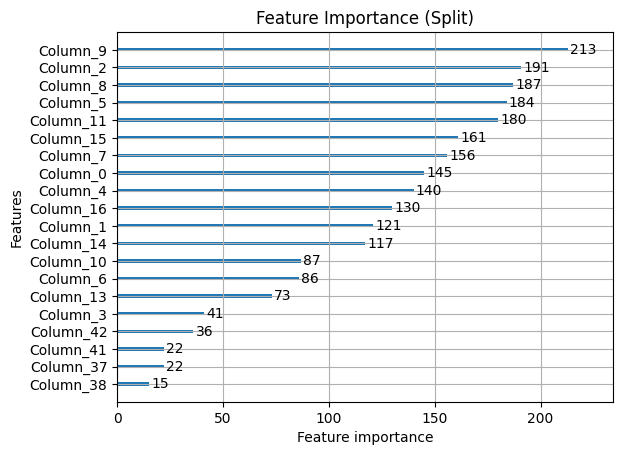

In [38]:
# Importancia 'Split'
predictor = LGBMClassifier(random_state=random_state, **study_lgbm.best_params, verbose=-1, importance_type='split')
optimized_pipeline = create_pipeline(generate_scaler(numeric_cols, categorical_cols), predictor)
optimized_pipeline.fit(X_train, y_train)
lgbm.plot_importance(predictor, max_num_features=20, title="Feature Importance (Split)")

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

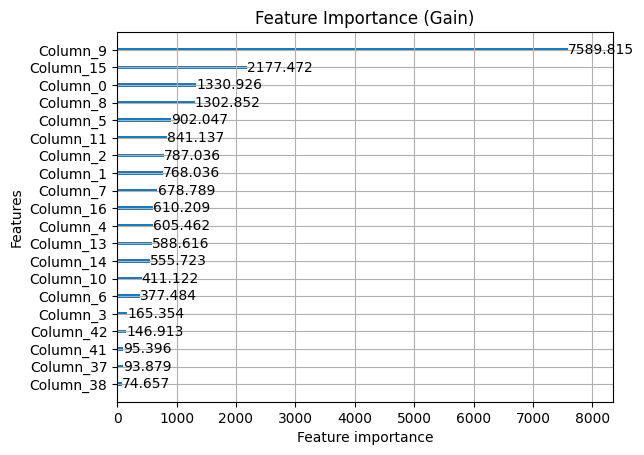

In [39]:
# Importancia 'Gain'
predictor = LGBMClassifier(random_state=random_state, **study_lgbm.best_params, verbose=-1, importance_type='gain')
optimized_pipeline = create_pipeline(generate_scaler(numeric_cols, categorical_cols), predictor)
optimized_pipeline.fit(X_train, y_train)
lgbm.plot_importance(predictor, max_num_features=20, title="Feature Importance (Gain)")

In [40]:
# Se calculan los resultados
result = permutation_importance(optimized_pipeline, X_test, y_test, n_repeats=30, random_state=random_state)
result

{'importances_mean': array([-0.00759734, -0.00503324, -0.0022792 , -0.0087686 , -0.00012662,
        -0.01012979,  0.06033555, -0.00493827,  0.0481798 ,  0.00639443,
         0.00091801, -0.00614118,  0.02371003, -0.00880025, -0.0025641 ,
        -0.00186768, -0.00291231, -0.0034188 , -0.00449509,  0.0008547 ]),
 'importances_std': array([0.00372676, 0.00271002, 0.00311707, 0.00360943, 0.00301044,
        0.00278857, 0.00916723, 0.00222582, 0.00615911, 0.00469058,
        0.0047069 , 0.00272753, 0.00842116, 0.00315859, 0.00496589,
        0.00211619, 0.00508425, 0.0037955 , 0.00321519, 0.00056716]),
 'importances': array([[-0.01139601, -0.01519468, -0.00664767, -0.01139601, -0.00949668,
         -0.00949668, -0.00379867, -0.00664767, -0.00664767, -0.00664767,
         -0.00949668, -0.00854701, -0.00094967, -0.00189934, -0.00854701,
         -0.00949668, -0.00664767, -0.00474834, -0.00664767, -0.00949668,
         -0.00474834, -0.01614435, -0.00664767, -0.00759734, -0.00949668,
        

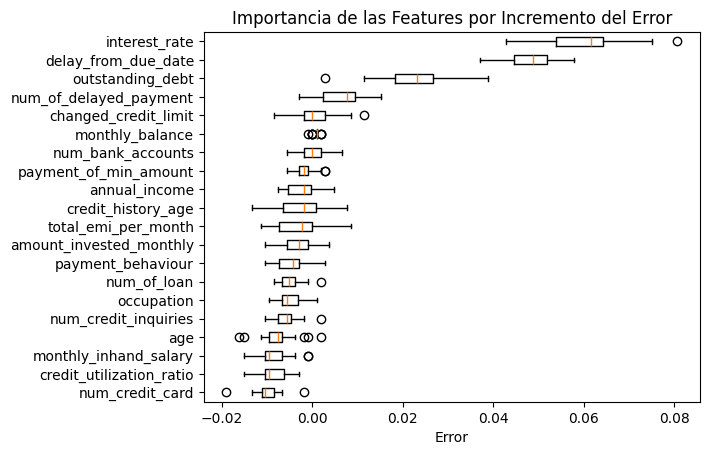

In [46]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx]
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

In [48]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [66]:
X_scaler = scaler.fit_transform(X)
X_preprocessed = imputer.fit_transform(X_scaler)

explainer = shap.TreeExplainer(predictor)
shap_values = explainer(X_preprocessed)
shap_values

.values =
array([[[ 0.26454316, -0.26454316],
        [ 0.05847355, -0.05847355],
        [ 0.10708574, -0.10708574],
        ...,
        [-0.00185054,  0.00185054],
        [ 0.03495182, -0.03495182],
        [ 0.02674513, -0.02674513]],

       [[ 0.69061161, -0.69061161],
        [-0.0579937 ,  0.0579937 ],
        [ 0.00259032, -0.00259032],
        ...,
        [ 0.0070971 , -0.0070971 ],
        [ 0.01344527, -0.01344527],
        [-0.08259745,  0.08259745]],

       [[ 0.4630726 , -0.4630726 ],
        [ 0.00114306, -0.00114306],
        [ 0.10812337, -0.10812337],
        ...,
        [-0.00259512,  0.00259512],
        [ 0.01479801, -0.01479801],
        [-0.01132392,  0.01132392]],

       ...,

       [[ 0.40794631, -0.40794631],
        [ 0.01300521, -0.01300521],
        [-0.02601421,  0.02601421],
        ...,
        [-0.00606839,  0.00606839],
        [ 0.02258824, -0.02258824],
        [ 0.09152224, -0.09152224]],

       [[-0.11260742,  0.11260742],
        [-0.09423

In [67]:
type(shap_values)

shap._explanation.Explanation

Aporte de las variables para la instancia 1


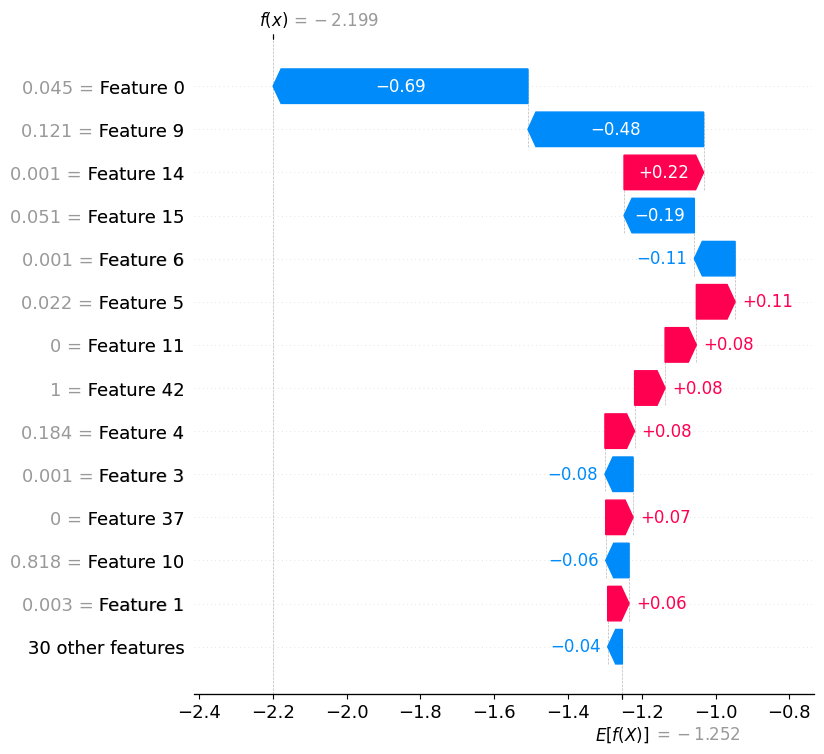

Aporte de las variables para la instancia 9


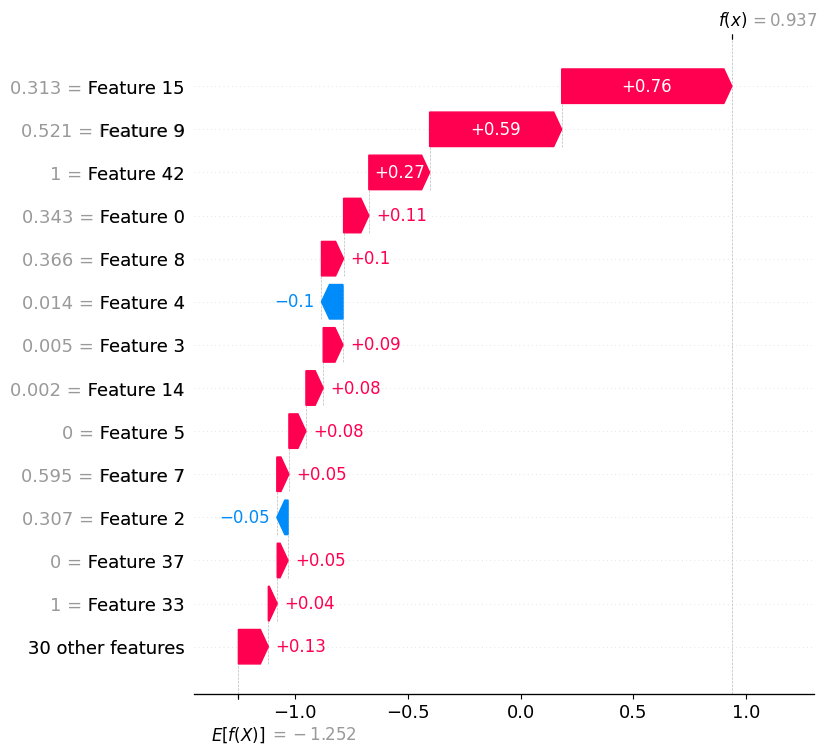

Aporte de las variables para la instancia 150


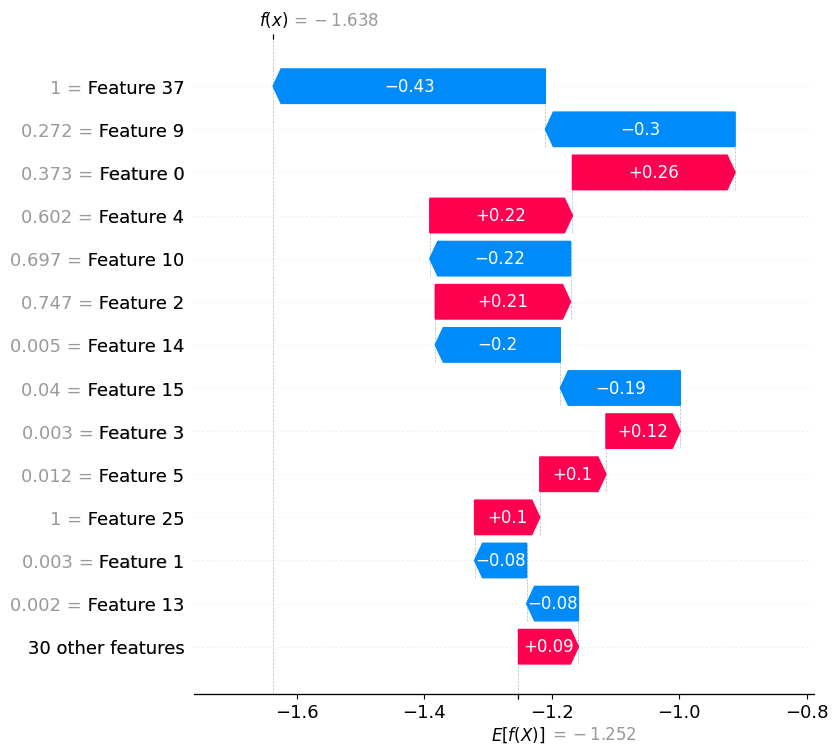

In [70]:
instancias = [1, 9, 150]

for i in instancias:
    print(f"Aporte de las variables para la instancia {i}")
    shap.plots.waterfall(shap_values[i, :, 1], max_display=14)

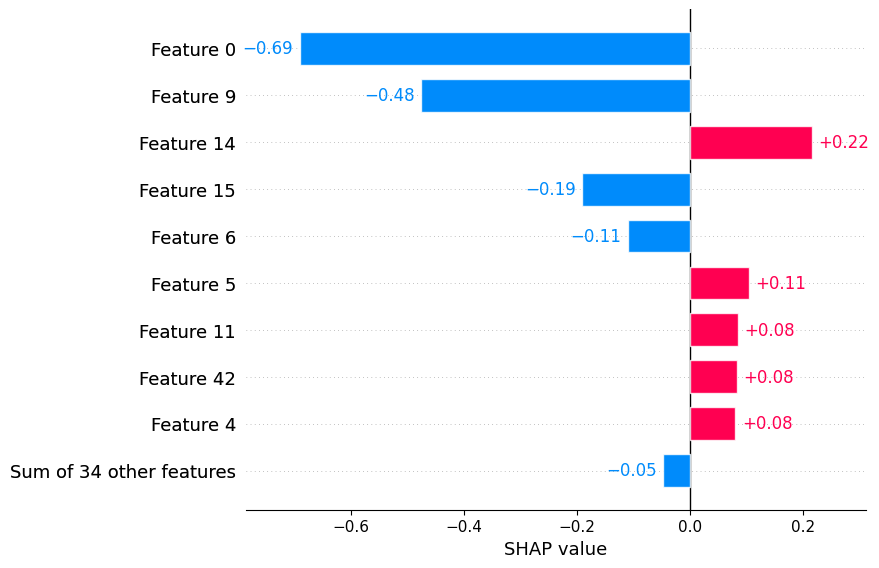

In [71]:
shap.plots.bar(shap_values[1, :, 1])

### Conclusiones

El problema quedó resuelto, ya que logramos crear un clasificador de personas que no pagan al banquero que efectivamente predice lo que se busca. Los resultados obtenidos no son perfectos, ya que el modelo deja afuera aproximadamente la mitad de las personas, pero ya es un gran avance al permitir al banquero eliminar a la mitad de las personas del banco.
**info del EDA**

El rendimiento del baseline del `LGBMClassifier` mejoró de 0.542 a 0.557 luego de optimizarse, es decir en un 2.77%. Si bien se logró optimizar el baseline y mejorar su capacidad de predicción, no es mucho ya que de por sí el clasificador es bastante bueno. Además, el hecho de que los datos estén desbalanceados no permiten una mejora mayor porque directamente no hay más datos para poder entrenarlo mejor.

Honestamente, podríamos haber tenido mejores resultados. Quizás si hubieramos abordado el problema más como "One-Class Classifier" habríamos tenido mucho mejores resultados, ya que solo estaríamos viendo si los nuevos datos están lo suficientemente cerca de la clase que queremos, en lugar de estar separándolos en dos clases, que necesita muchos más datos. Ahí, usando un algoritmo de clustering habría sido una buena opción.

**que aprendimos xd**